In [1]:
import torch as t
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ast import literal_eval

from sklearn.manifold import TSNE
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import AutoMinorLocator, MaxNLocator

import sys
sys.path.append('..')
from utils.model import get_transformer
from utils.data import SimpleTokenizer

sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300

head_props_df = pd.read_csv("../data/transformer_head_properties.csv")

#### TSNE Plots

In [2]:
transformer_df = pd.read_csv("../data/transformers_sweep_data_cutoffs_vecs.csv")
indist_preds = pd.read_csv("../data/model_preds/indist_data_preds.csv")
ood_preds = pd.read_csv("../data/model_preds/ood_data_preds.csv")

transformer_df["indist_preds_vec"] = [indist_preds[col].values for col in transformer_df["id"].values]
transformer_df["ood_preds_vec"] = [ood_preds[col].values for col in transformer_df["id"].values]

transformer_df['ood_test_acc_vector'] = transformer_df['ood_test_acc_vector'].apply(literal_eval)
transformer_df['final_ood_test_acc'] = transformer_df['ood_test_acc_vector'].apply(lambda x: x[-1] if x else None)

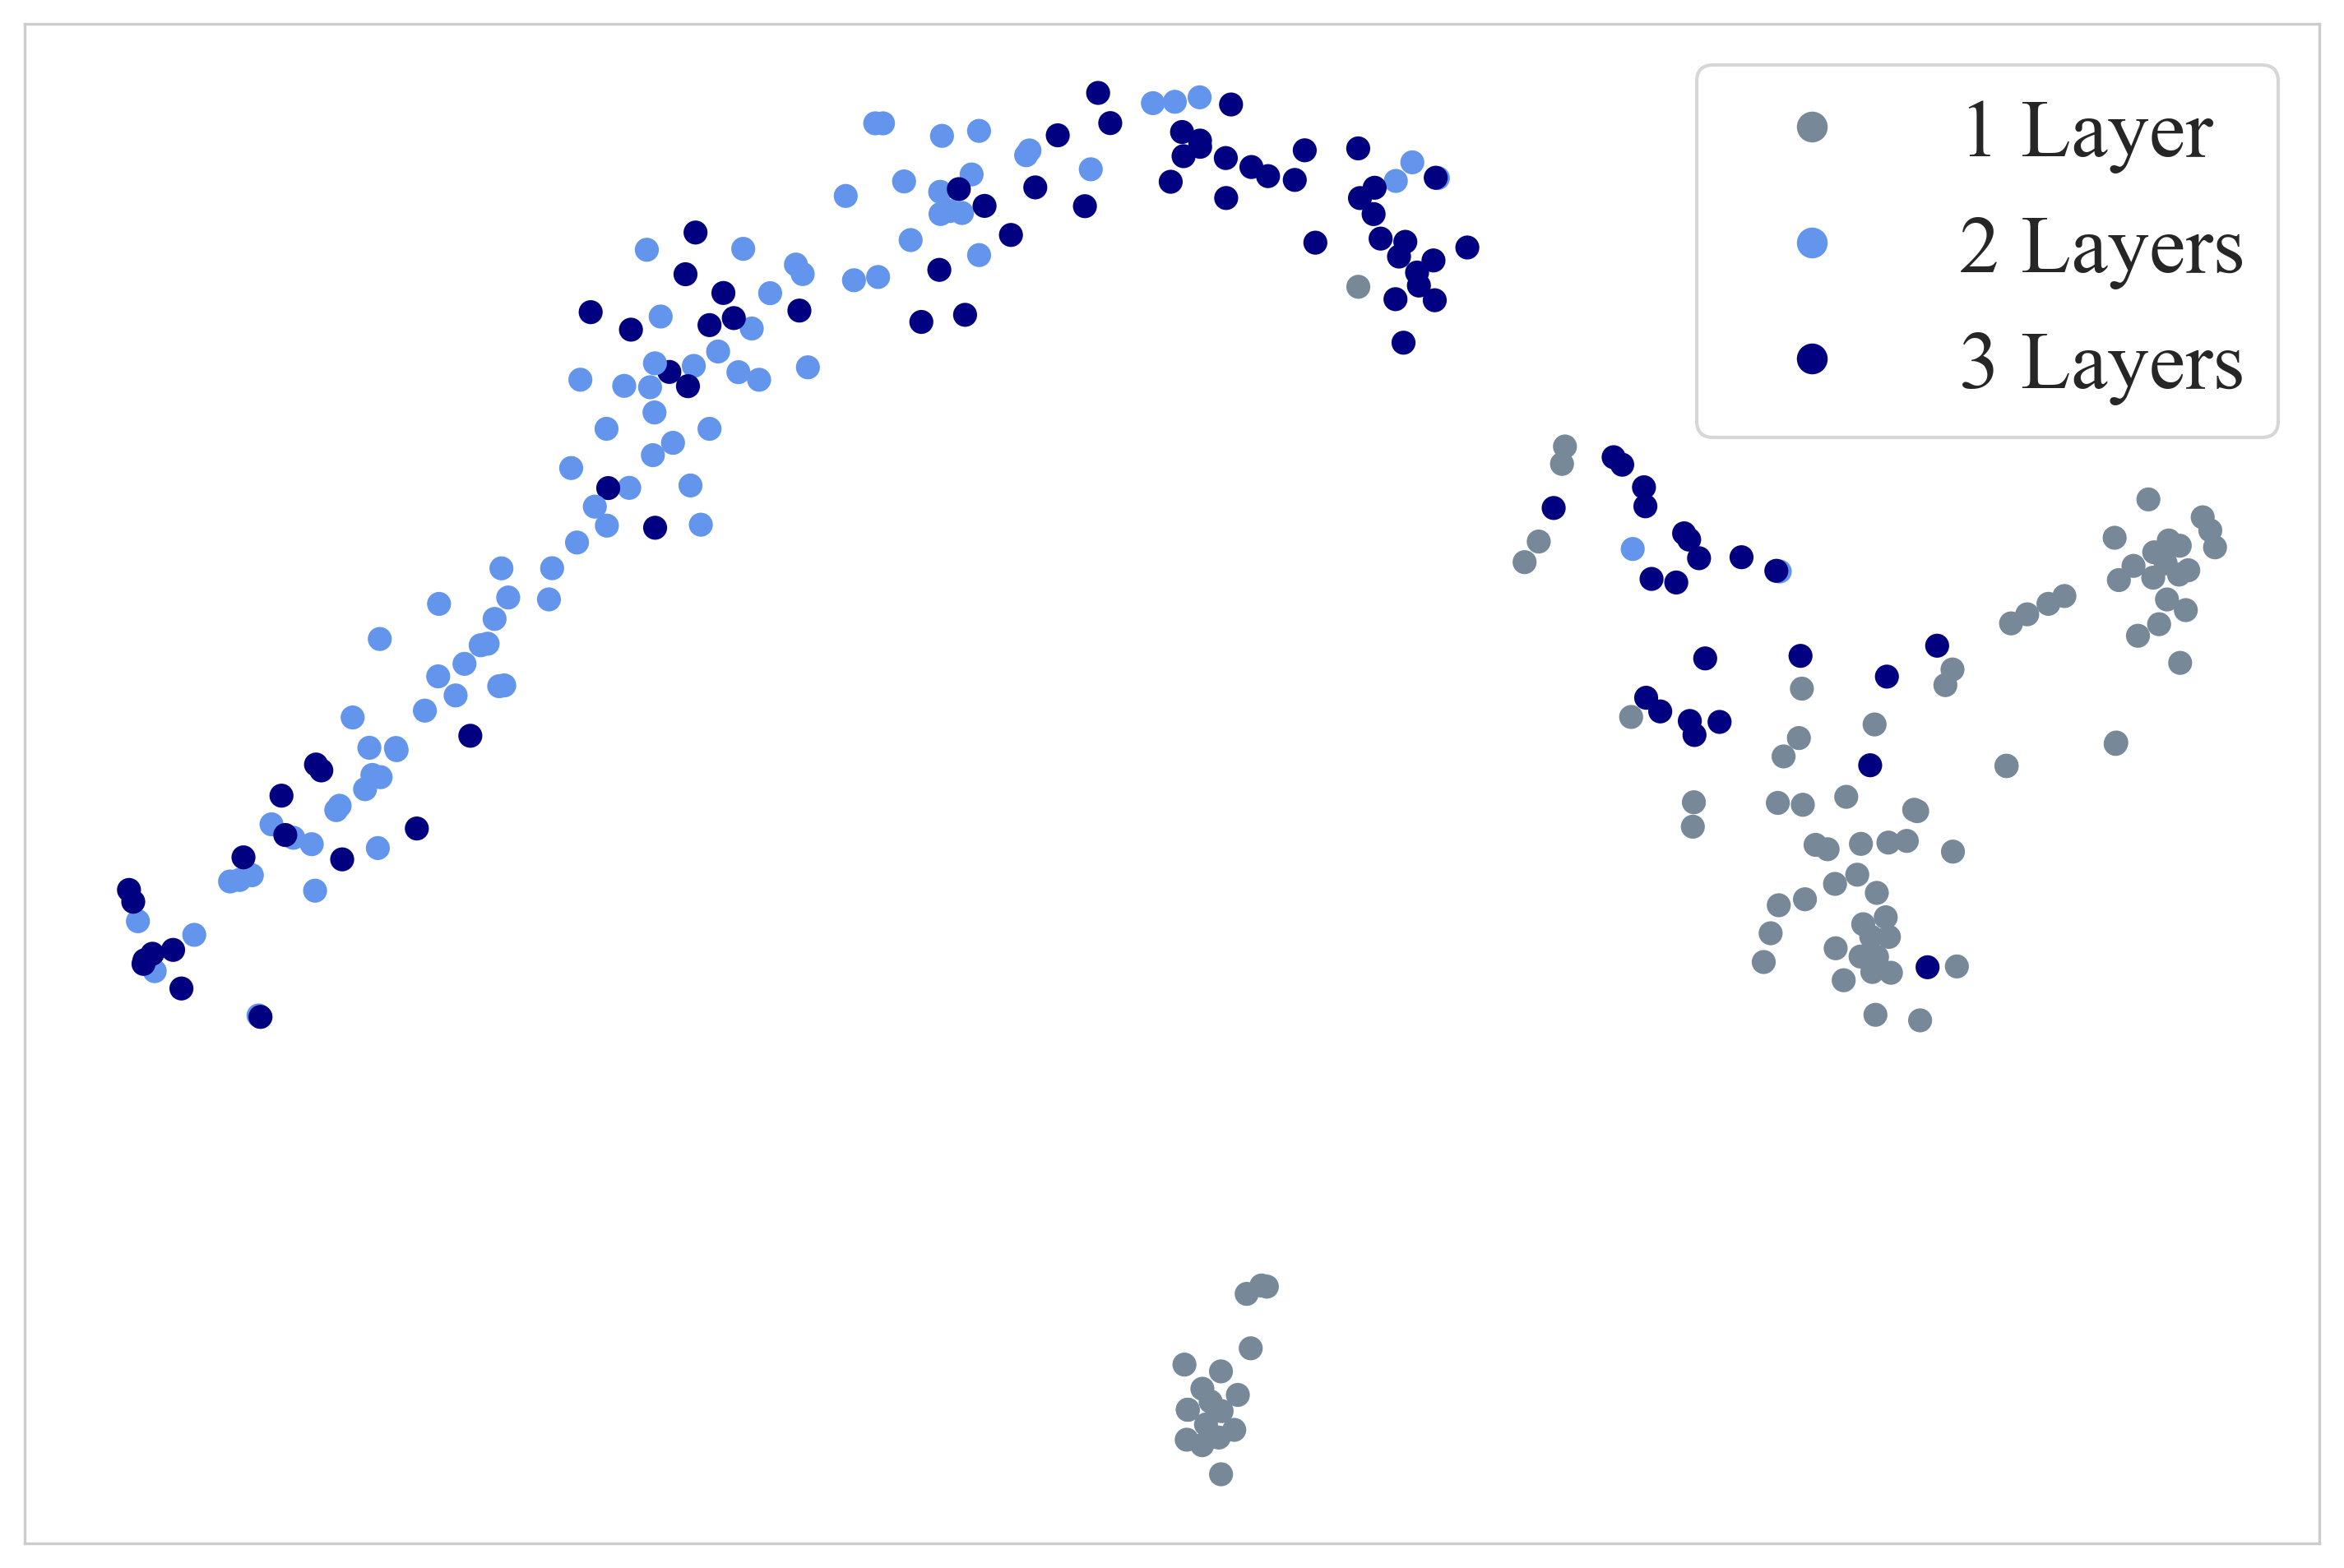

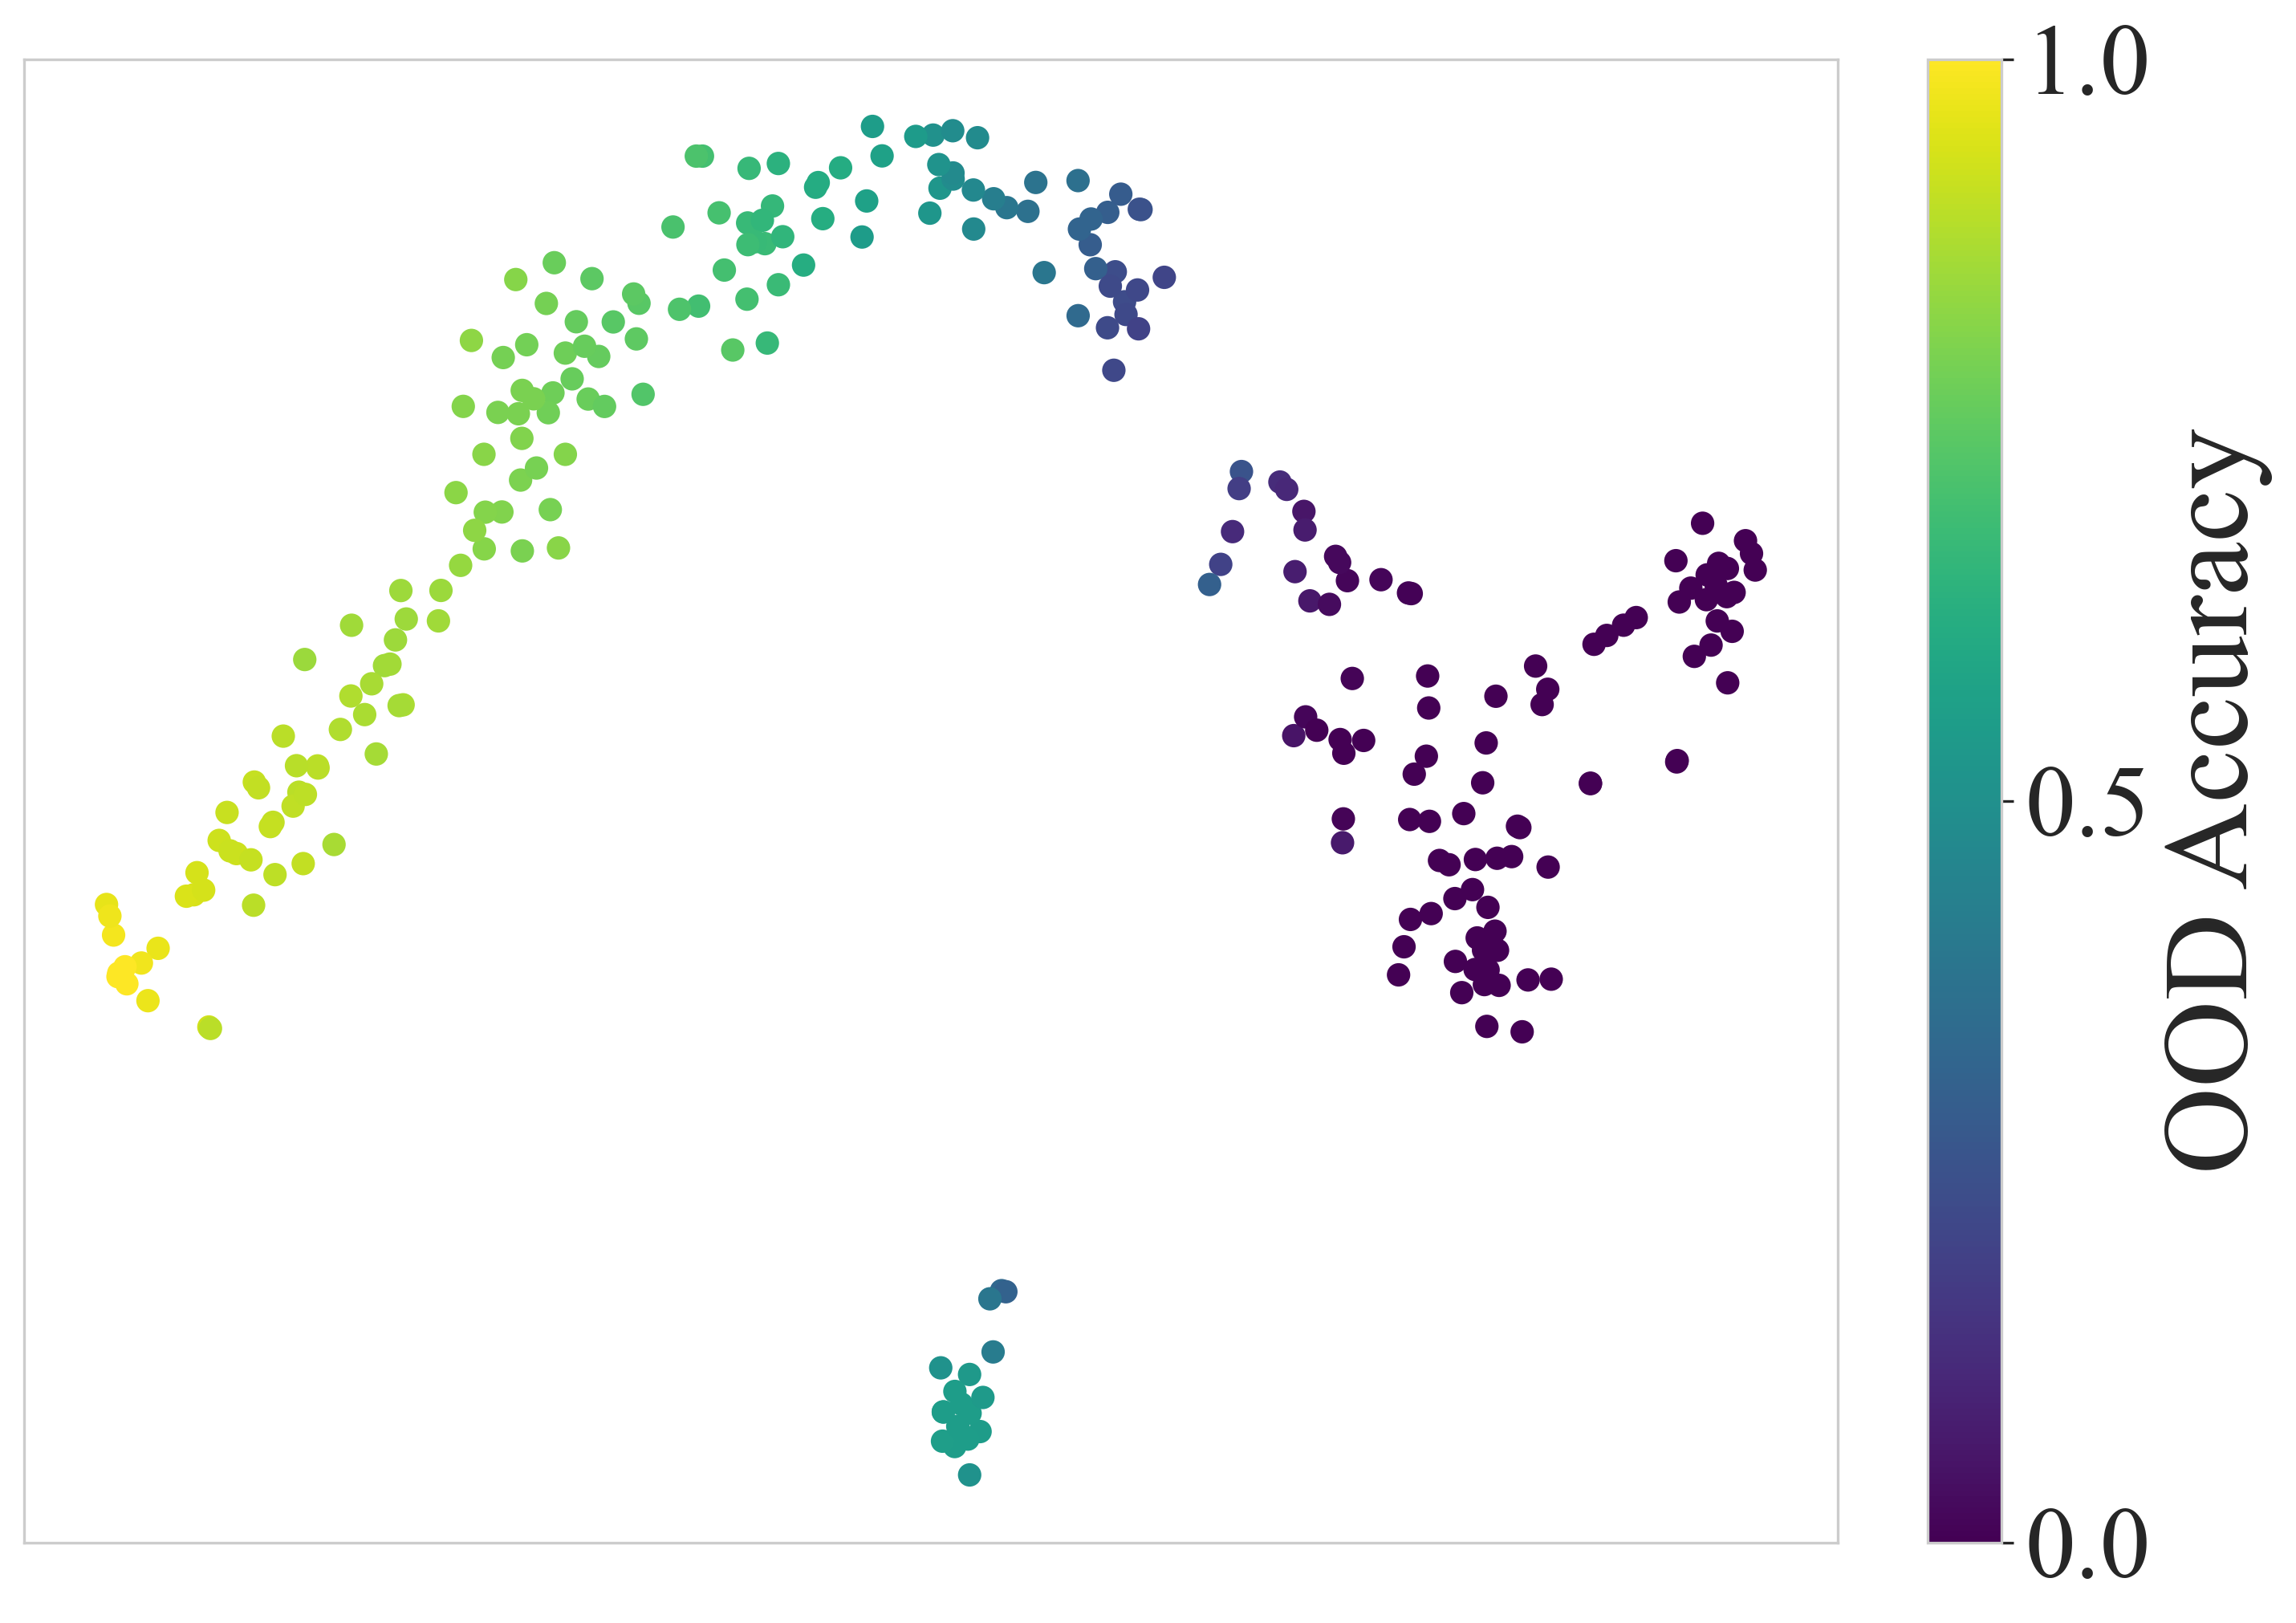

In [3]:
def get_tsne_plot(color_by:str):
    X = np.array(transformer_df['ood_preds_vec'].tolist())

    tsne = TSNE(n_components=2, random_state=73, perplexity=14)
    X_tsne = tsne.fit_transform(X)
    
    # get scatter
    plt.figure(figsize=(12, 8))
    
    if color_by == "n_layer":
        colors = []
        for layer in transformer_df['n_layer']:
            if layer == 1:
                colors.append("#778899")
            elif layer == 2:
                colors.append("#6495ed")
            else: # layer == 3
                colors.append("#000080")
        scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors)
        
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor="#778899", markersize=10, label='1 Layer'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor="#6495ed", markersize=10, label='2 Layers'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor="#000080", markersize=10, label='3 Layers')
        ]
        plt.legend(handles=legend_elements, loc='upper right', fontsize=24)
    else:
        scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                            c=transformer_df['final_ood_test_acc'],
                            cmap='viridis')
        colorbar = plt.colorbar(scatter, label='OOD Accuracy', ticks=[0, 0.5, 1], pad=0.04)
        colorbar.ax.tick_params(labelsize=30)
        colorbar.ax.set_ylabel('OOD Accuracy', fontsize=36)
    plt.xticks([])
    plt.yticks([])
    plt.show()

get_tsne_plot(color_by="n_layer")
get_tsne_plot(color_by="final_ood_test_acc")

#### ID Hierarchical Head Boxplots

In [4]:
def max_head_score(row, head_type, layer, checkpoint, indist_or_ood):
    if layer < 1 or layer > row['n_layer']:
        return 0
    if head_type == 'bracket':
        return max(max_head_score(row, 'open', layer, checkpoint, indist_or_ood), max_head_score(row, 'close', layer, checkpoint, indist_or_ood))
    return max([row[f"cp{checkpoint}_{head_type}_head_l{layer}_h{head_num}_{indist_or_ood}"] for head_num in [1,2,3,4]])

def has_head_type(row, head_type, checkpoint=5, threshold=0.5, indist_or_ood='ood', layer_or_layers=[1,2,3]):
    if type(layer_or_layers) is int:
        return max_head_score(row, head_type, layer_or_layers, checkpoint, indist_or_ood) >= threshold
    else:
        return any([max_head_score(row, head_type, layer, checkpoint, indist_or_ood) >= threshold for layer in layer_or_layers])

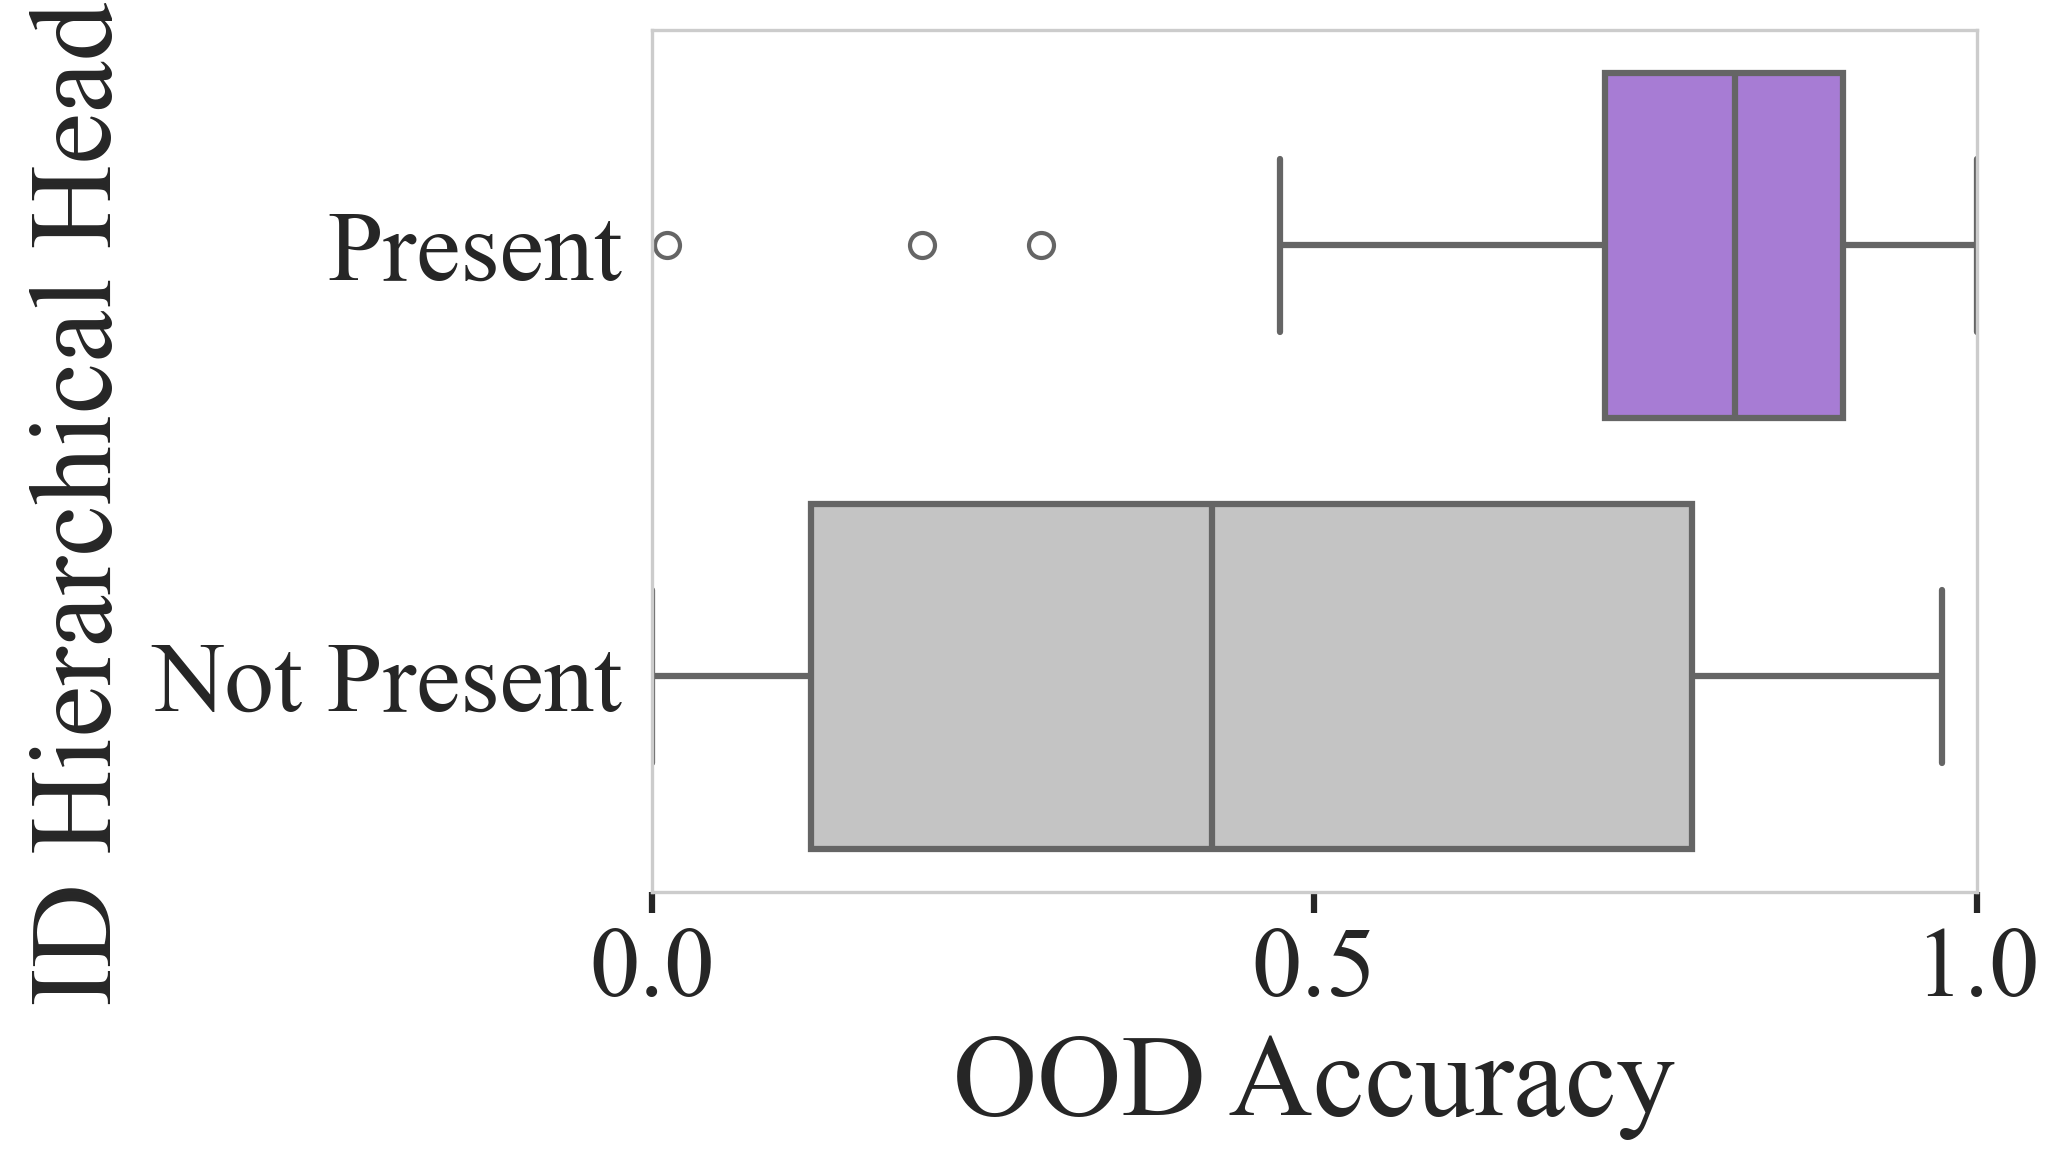

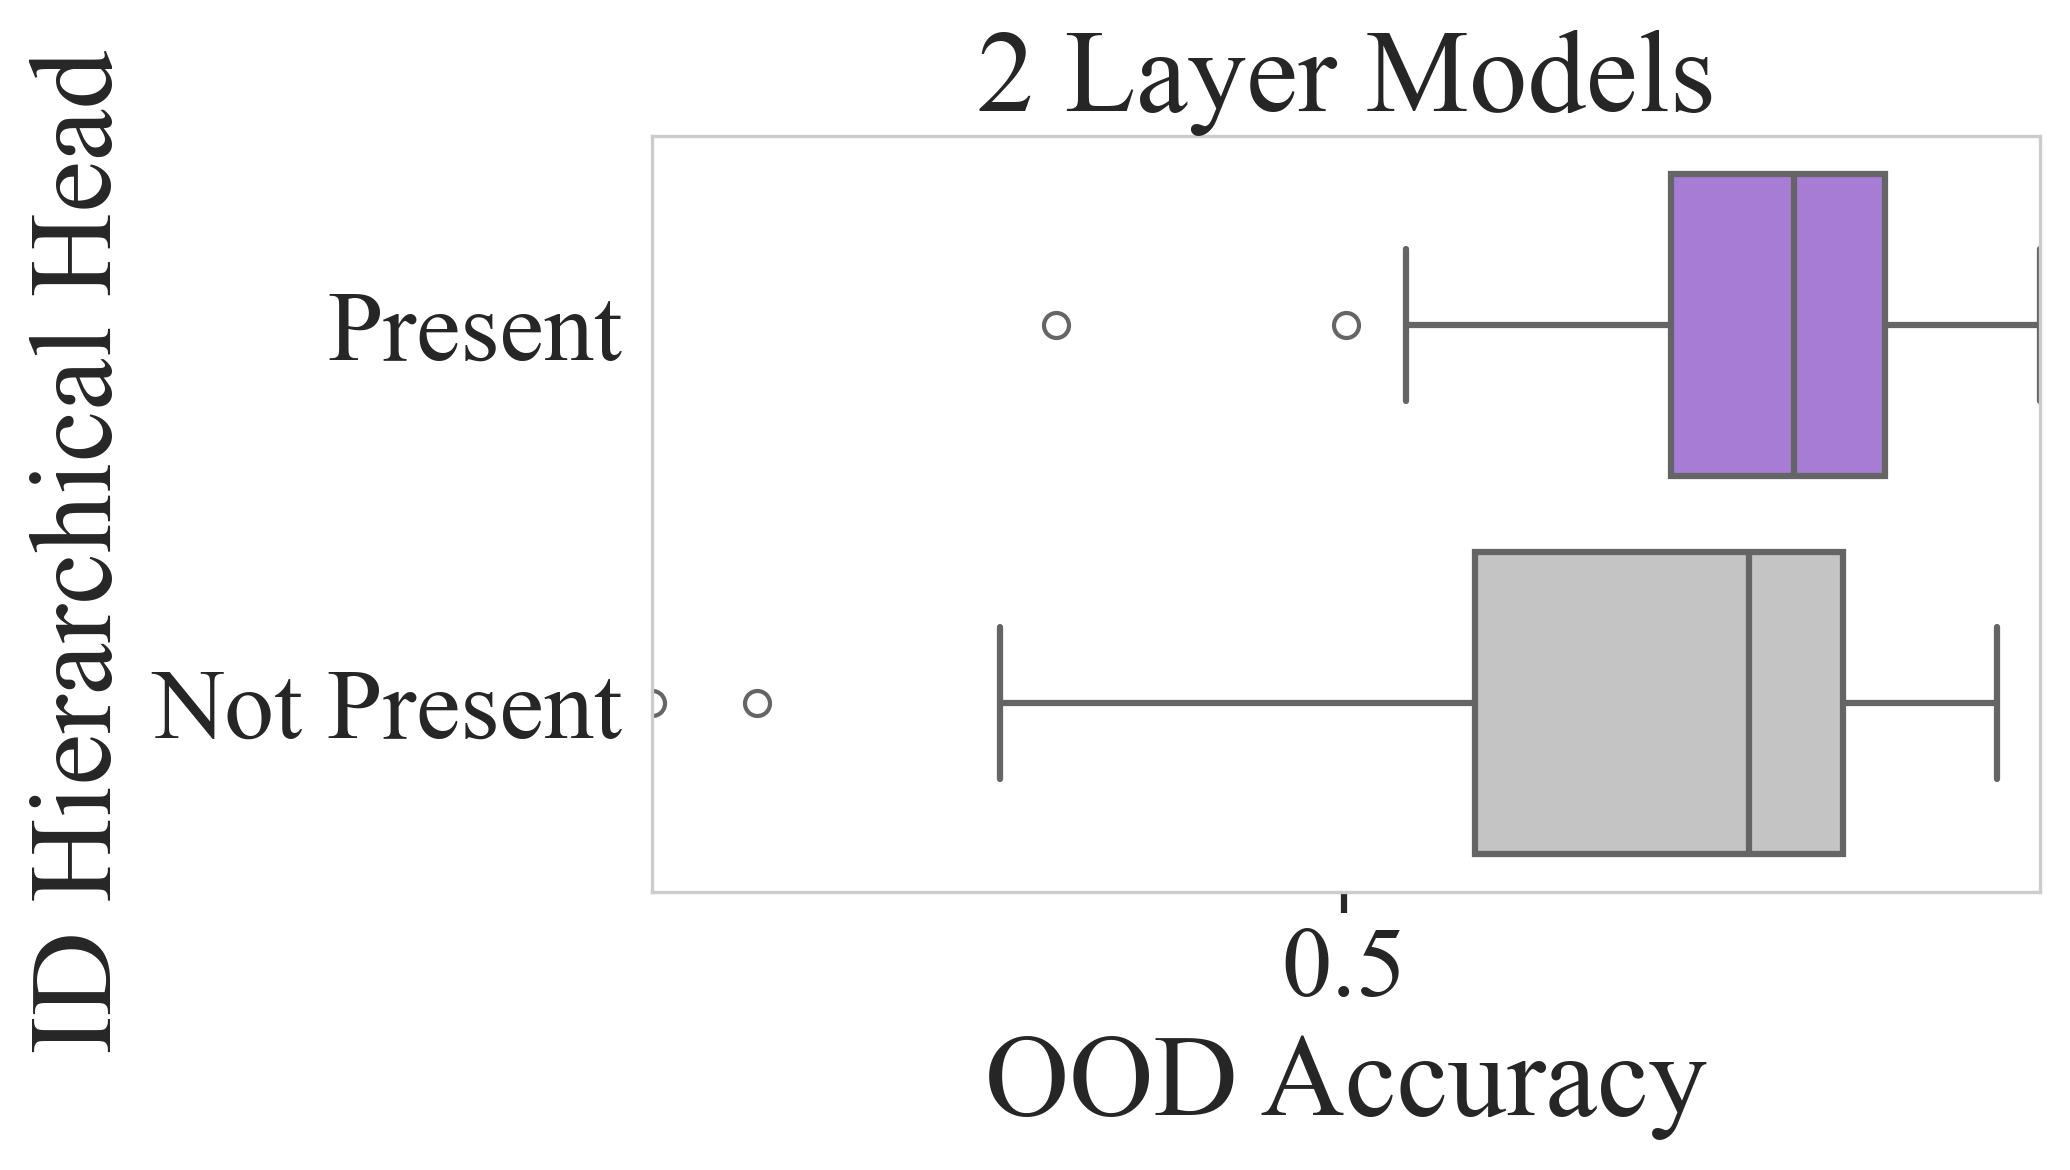

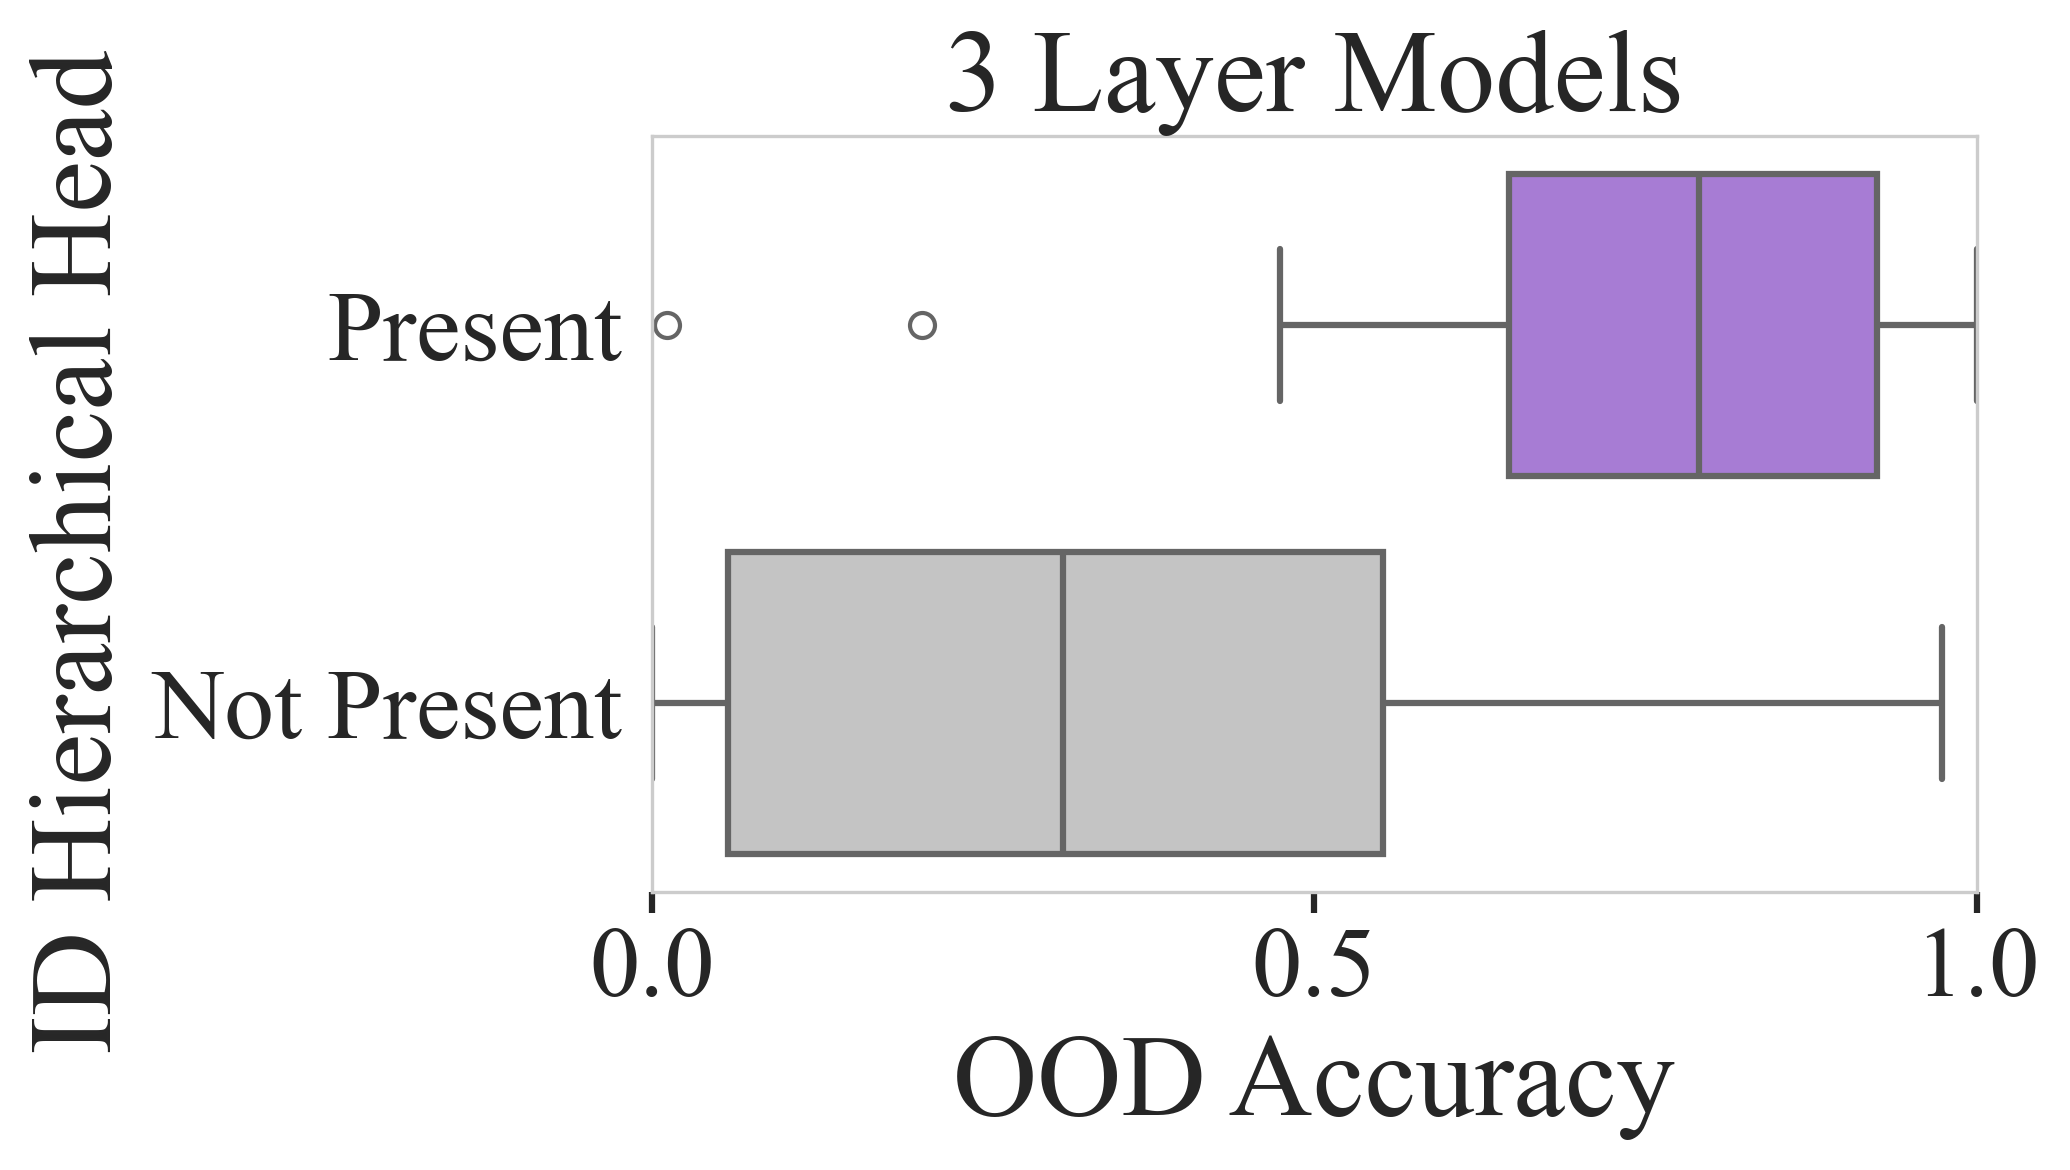

In [5]:
def box_plot(df, indist_or_ood='indist', title=""):
    assert indist_or_ood in ['indist', 'ood']
    # 'ambi' refers to a hierarchical/depth-detecting head
    head_type, y_label = 'ambi', 'ID Hierarchical Head'

    plot_data = []
    for _, row in df.iterrows():
        ood_acc = row['cp5_ood_acc']
        if has_head_type(row, head_type, threshold=0.8, indist_or_ood=indist_or_ood):
            value = 'Present'
        else:
            value = 'Not Present'
        plot_data.append({
            'Value': value,
            'OOD Acc': ood_acc,
        })

    data = pd.DataFrame(plot_data)
    plt.figure(figsize=(7, 4))
    color_palette = {'Present': '#a66de3', 'Not Present': '#C4C4C4'}

    data['Value'] = pd.Categorical(data['Value'], categories=['Present', 'Not Present'], ordered=True)
    data = data.sort_values('Value')
    
    ax = sns.boxplot(
        x='OOD Acc',
        y='Value',
        data=data,
        orient='h',
        hue='Value',
        palette=color_palette,
        legend=False,
        linewidth=1.5 
    )

    for patch in ax.artists:
        patch.set_edgecolor('black')

    plt.title(title, fontsize=28)
    plt.ylabel(y_label, fontsize=28, y=0.45)
    plt.xlabel('OOD Accuracy', fontsize=28)
    plt.xticks([0, 0.5, 1])
    plt.tick_params(axis='x', width=1.5, length=5)
    plt.margins(x=0)
    plt.tick_params(axis='both', which='major', labelsize=24)
    
    plt.grid(False)
    ax.spines['bottom'].set_visible(True)
    ax.xaxis.set_ticks_position('bottom')

    plt.tight_layout()
    plt.show()

box_plot(head_props_df[head_props_df['n_layer'].isin([2,3])])

for n_layer in [2,3]:
    box_plot(head_props_df[head_props_df['n_layer'] == n_layer], title=f"{n_layer} Layer Models")

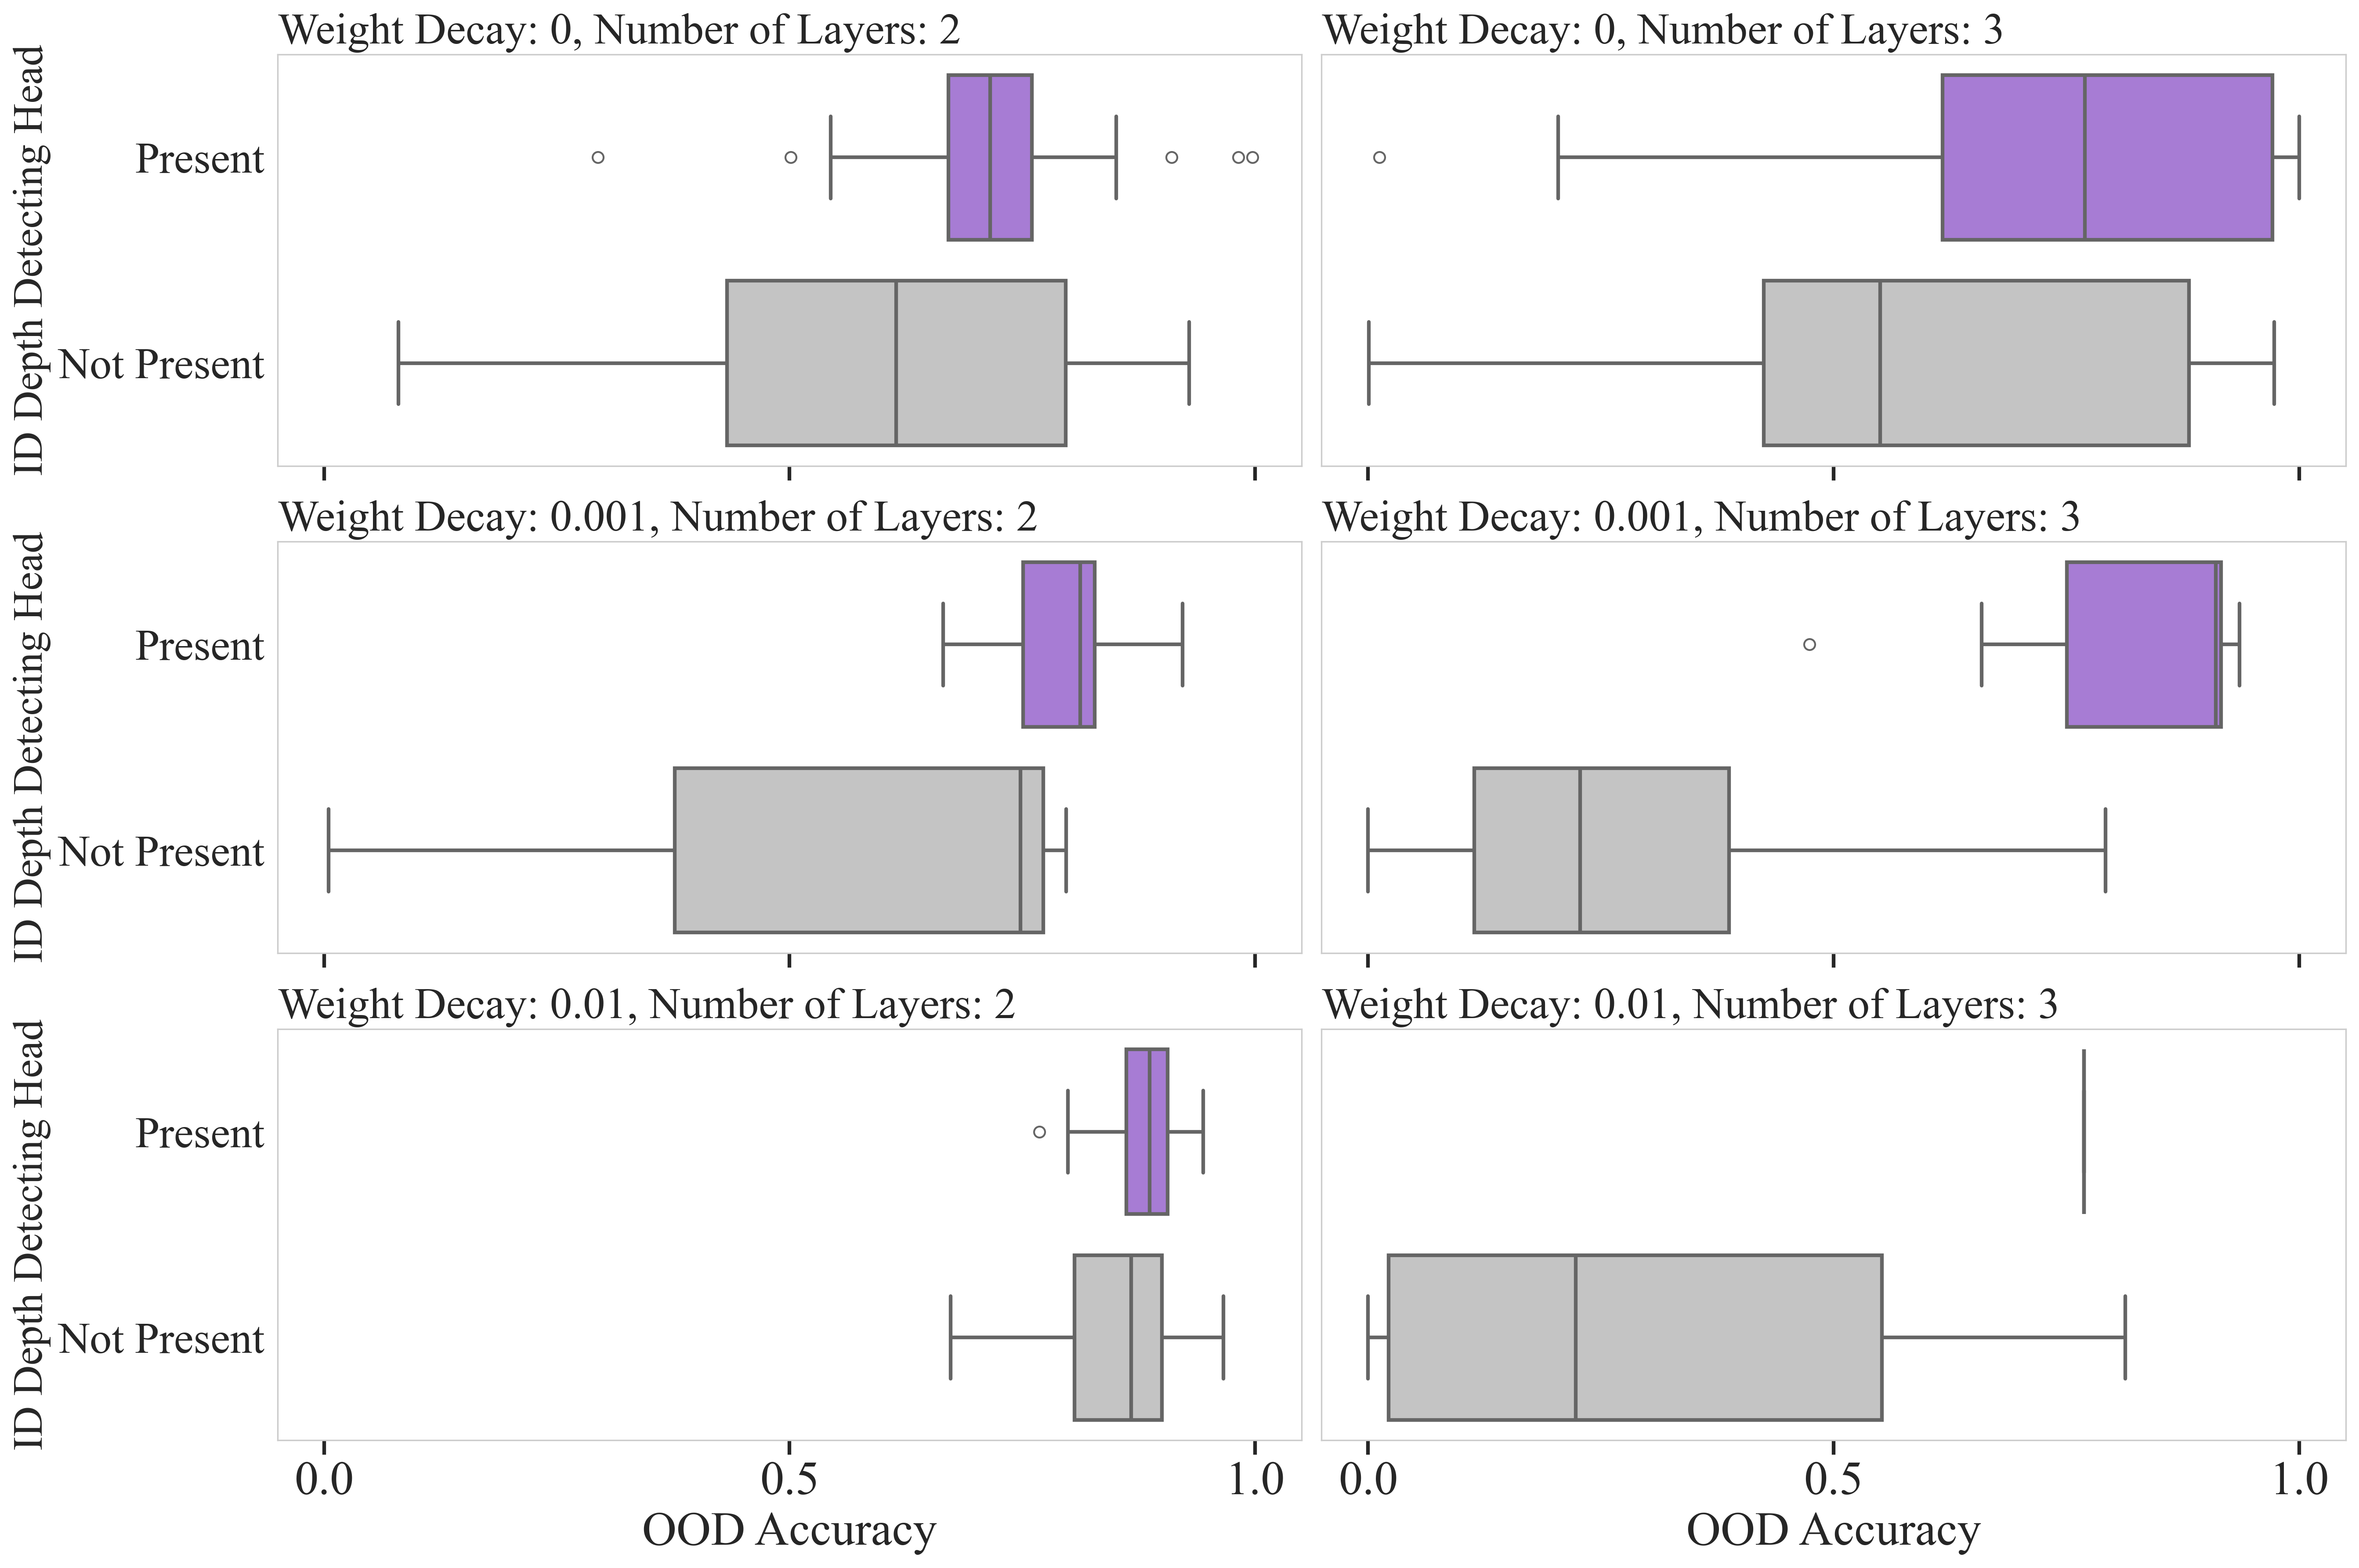

In [6]:
def create_stacked_hierchical_head_box_plots(df):
    """
    Create a stacked box plot showing depth-detecting heads across different layer counts and weight decay values,
    with each subplot labeled by wd and n_layer, and a consistent y-axis label.
    """
    fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=True, sharey=True)

    color_palette = {'Present': '#a66de3', 'Not Present': '#C4C4C4'}

    # all combinations - n_layer as cols
    combinations = [(wd, n_layer) for wd in [0, 0.001, 0.01] for n_layer in [2, 3]]

    for idx, (wd, n_layer) in enumerate(combinations):
        row = idx // 2
        col = idx % 2 
        ax = axes[row, col]

        # data for this combination
        filtered_df = df[(df['n_layer'] == n_layer) & (df['wd'] == wd)]
        plot_data = []
        for _, row_data in filtered_df.iterrows():
            ood_acc = row_data['cp5_ood_acc']
            if has_head_type(row_data, 'ambi', threshold=0.8, indist_or_ood='indist'):
                label = 'Present'
            else:
                label = 'Not Present'
            plot_data.append({'ID Depth Detecting Head': label, 'OOD Acc': ood_acc})

        data = pd.DataFrame(plot_data)
        data['ID Depth Detecting Head'] = pd.Categorical(
            data['ID Depth Detecting Head'],
            categories=['Present', 'Not Present'], ordered=True
        )
        data = data.sort_values('ID Depth Detecting Head')

        sns.boxplot(
            x='OOD Acc',
            y='ID Depth Detecting Head',
            data=data,
            orient='h',
            hue='ID Depth Detecting Head',
            palette=color_palette,
            legend=False,
            linewidth=2.0, 
            ax=ax
        )

        ax.set_title(f"Weight Decay: {wd}, Number of Layers: {n_layer}", fontsize=24, loc='left')

        # common tick positions and style
        ax.set_xticks([0, 0.5, 1])
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(axis='x', which='both', length=8, width=2)

        # y-axis label only on first column
        if col == 0:
            ax.set_ylabel('ID Depth Detecting Head', fontsize=23)
        else:
            ax.set_ylabel('')
        ax.tick_params(axis='y', labelsize=24)

        if row == 2: # bottom row
            ax.tick_params(
                axis='x', which='major',
                labelbottom=True,
                labelsize=26,
                length=8,
                width=2,
            )
            ax.set_xlabel('OOD Accuracy', fontsize=26)
        else:
            ax.tick_params(labelbottom=False)
            ax.set_xlabel('')
        ax.grid(False)

    plt.tight_layout()
    plt.show()

create_stacked_hierchical_head_box_plots(head_props_df)

#### Hierarchical Attention Pattern Example

In [7]:
def get_selection(head_props_df):
    neg_cols    = [c for c in head_props_df.columns 
                if c.startswith('cp5_neg_head')    and c.endswith('_indist')]
    nonneg_cols = [c for c in head_props_df.columns 
                if c.startswith('cp5_nonneg_head') and c.endswith('_indist')]

    # pick two runs + desired sign of head-of-interest
    target_ids = [("gkh8ipkk", "neg"), ("8dr77y3h", "nonneg")]

    rows = []
    for run_id, sign in target_ids:
        cols = neg_cols if sign == "neg" else nonneg_cols
        sub = head_props_df.loc[
            head_props_df["id"] == run_id,
            ["id"] + cols
        ]

        # melt and get single largest val
        long = sub.melt(
            id_vars="id",
            value_vars=cols,
            var_name="col",
            value_name="val"
        )
        best = long.nlargest(1, "val").copy()
        best["sign"] = sign
        rows.append(best)

    selection = pd.concat(rows, ignore_index=True)
    return selection 

def get_tokens_depths_masks(tokens_as_string):
    tokenizer = SimpleTokenizer(alphabet="()")
    tokens = tokenizer.tokenize(tokens_as_string)[0]

    # mask for non‑pad tokens (assumes 1 == pad)
    mask = tokens != 1
    idx = mask.nonzero().squeeze()
    # human‑readable token labels, strip BOS/EOS
    labels = [tokenizer.i_to_t[int(x)] for x in tokens if int(x) != 1][1:-1]

    depth = 0
    depths = []
    for tok in labels:
        if tok == "(":
            depth += 1
        elif tok == ")":
            depth -= 1
        depths.append(depth)
    depths = np.array(depths)
    nonneg_mask = depths >= 0

    return tokens, idx, depths, nonneg_mask

def get_attn_maps(tokens_as_string, selection, all_sweeps_df):
    tokens, idx, depths, nonneg_mask = get_tokens_depths_masks(tokens_as_string)
    print("Non-neg mask: ", nonneg_mask)
    assert "id" in selection.columns, "selection must have an 'id' column"
    assert "col" in selection.columns, "selection must have a 'col' column"
    assert "sign" in selection.columns, "selection must have a 'sign' column"
    
    checkpoint = 5
    attn_maps = []
    signs     = []
    device = t.device('cuda' if t.cuda.is_available() else 'cpu')

    for _, (run_id, col, sign) in selection[['id','col','sign']].iterrows():
        # parse layer/head
        parts = col.split('_')
        layer = int(parts[3][1:])
        head  = int(parts[4][1:])
        row   = all_sweeps_df.loc[all_sweeps_df['id']==run_id].iloc[0]

        # build & load
        model = get_transformer(
            n_layer=int(row['n_layer']),
            n_head =int(row['n_head']),
            n_embd =int(row['n_embd']),
            embd_pdrop=float(row['embd_pdrop']),
            attn_pdrop=float(row['attn_pdrop']),
            resid_pdrop=float(row['resid_pdrop'])
        ).to(device).eval()
        model.load_state_dict(t.load(
            f"data/model_weights/run_{run_id}/run_{run_id}_checkpoint_{checkpoint}.pt",
            map_location=device
        ))

        # forward & grab attention
        with t.no_grad():
            _    = model(tokens.to(device).unsqueeze(0))
            attn = model.get_attention_weights()[f"layer_{layer}_head_{head}"]  # [seq,seq]

        sub_attn    = attn[idx][:,idx][1:-1,1:-1]  # drop BOS/EOS
        last_attn   = sub_attn[-1].cpu().numpy()  # shape [toks]
        attn_maps.append(last_attn)
        signs.append(sign)

    data = np.stack(attn_maps, axis=0)
    
    return data, signs, depths

In [8]:
selection = get_selection(head_props_df)

COL_LP   = "#048484"   # token  '('
COL_RP   = "#be0c4a"   # token  ')'
COL_NNEG = "#4c4ccc"   # "Non‑Negative" label
COL_NEG  = "#cc4d4d"   # "Negative" label
COL_DEP_P= "#4c4ccc"   # depth ≥ 0   (distinct from token colours)
COL_DEP_N= "#cc4d4d"   # depth  < 0   (distinct from token colours)

ylgnbu_cmap = plt.get_cmap('YlGnBu')
colors = [ylgnbu_cmap(0), ylgnbu_cmap(0.35), ylgnbu_cmap(0.65)]
cmap_custom = LinearSegmentedColormap.from_list("YellowToYlGnBuGreenToPurple", colors, N=256)

def get_heatmap(selection, all_sweeps_df, token_as_string):
    label_size = 52
    data, signs, depths = get_attn_maps(token_as_string, selection, all_sweeps_df)
    y_labels = ['Non-Negative' if s != 'neg' else 'Negative' for s in signs]
    n_cols   = data.shape[1]

    h_ratios = [1.5, 1.5, 3.0, 3.0, 0.35]
    fig_h    = 1.05 * sum(h_ratios)
    fig      = plt.figure(figsize=(2.5 * n_cols, fig_h))
    gs       = fig.add_gridspec(5, 1, height_ratios=h_ratios, hspace=0.3)

    ax_seq  = fig.add_subplot(gs[0, 0])
    ax_dep  = fig.add_subplot(gs[1, 0])
    ax_hm   = fig.add_subplot(gs[2:4, 0])
    ax_cbar = fig.add_subplot(gs[4, 0])
    
    # row 0: sequence
    ax_seq.set_xlim(0, n_cols); ax_seq.set_ylim(0, 1); ax_seq.axis("off")
    ax_seq.text(-0.26, 0.5, "Sequence", transform=ax_seq.transAxes,
                ha="left", va="center", fontsize=label_size, fontweight="bold")
    for i, ch in enumerate(token_as_string):
        ax_seq.text(i + 0.5, 0.5, ch,
                    ha="center", va="center",
                    fontsize=label_size, fontweight="bold",
                    color=COL_LP if ch == "(" else COL_RP)

    # row 1: depth
    ax_dep.set_xlim(0, n_cols); ax_dep.set_ylim(0, 1); ax_dep.axis("off")
    ax_dep.text(-0.18, 0.5, "Depth", transform=ax_dep.transAxes,
                ha="left", va="center", fontsize=label_size, fontweight="bold")
    
    # get grid cells with colored edges
    for i, d in enumerate(depths):
        cell_color = COL_DEP_P if d >= 0 else COL_DEP_N
        
        rect = plt.Rectangle((i + 0.1, 0.05), 0.8, 0.8, 
                           fill=False, edgecolor=cell_color, linewidth=8)
        ax_dep.add_patch(rect)
        ax_dep.text(i + 0.5, 0.4, str(d),
                    ha="center", va="center",
                    fontsize=label_size, fontweight="bold",
                    color=cell_color)

    # rows 2+3: attention heat‑map
    hm = sns.heatmap(data,
                     cmap=cmap_custom,
                     xticklabels=False,
                     yticklabels=y_labels,
                     cbar=False,
                     ax=ax_hm,
                     linewidths=15,
                     linecolor='white')

    ax_hm.set_ylabel("")
    for tick, s in zip(ax_hm.get_yticklabels(), signs):
        tick.set_color(COL_NNEG if s != "neg" else COL_NEG)
        tick.set_fontweight("bold")
        tick.set_fontsize(label_size)
        tick.set_rotation(0)

    # add colored outlines to specific cells
    for col_idx in [1, 3]:
        rect = plt.Rectangle((col_idx+1.03, 0.03), 0.9, 0.9, 
                           fill=False, edgecolor=COL_NEG, linewidth=8)
        ax_hm.add_patch(rect)
    
    for col_idx in [0, 1, 3, 5]: 
        rect = plt.Rectangle((col_idx+0.04, 1.06), 0.9, 0.9, 
                           fill=False, edgecolor=COL_NNEG, linewidth=8)
        ax_hm.add_patch(rect)

    # row 4: compact colour‑bar
    img   = hm.collections[0]
    ticks = [0.08, 0.16]
    cbar  = fig.colorbar(img, cax=ax_cbar,
                        orientation="horizontal", ticks=ticks)
    cbar.outline.set_linewidth(1)
    cbar.outline.set_edgecolor('black')

    # style the major ticks (with labels)
    cbar.ax.tick_params(which="major", labelsize=label_size-4, length=9, width=5)

    # add minor ticks 
    cbar.ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    cbar.ax.tick_params(which="minor", length=9, width=4)

    ax_cbar.text(0.5, 1.2, "Attention Activations", ha="center", va="bottom", 
                fontsize=label_size, transform=ax_cbar.transAxes)
    
    cbar.ax.set_position([0.2, 0, 0.6, 0.05])

    plt.show()

get_heatmap(selection, head_props_df, "())()(")

Non-neg mask:  [ True  True False  True False  True]


FileNotFoundError: [Errno 2] No such file or directory: 'data/model_weights/run_gkh8ipkk/run_gkh8ipkk_checkpoint_5.pt'

#### Impact of Ablation -- Hierachical Head Type Breakdown 

In [ ]:
def most_impactful_head(ablated_row, layer, checkpoint, by_ood=True):
    ood_or_indist = "ood" if by_ood else "indist"
    original_acc = ablated_row[f'cp{checkpoint}_{ood_or_indist}_acc']
    most_impactful_head = 1
    max_diff = 0
    for head in range(1, 5):
        key = f"l{layer}_h{head}_{ood_or_indist}"
        key = f"cp{checkpoint}_{key}"
        if key in ablated_row:
            if ablated_row[key] != -1:
                diff = ablated_row[key] - original_acc
                if abs(diff) > abs(max_diff):
                    max_diff = diff
                    most_impactful_head = head
    key = f"layer_{layer}_head_{most_impactful_head}"
    return key, max_diff

def scatter_plot_multilayers(df,
                             head_type1="sign",
                             head_type2="neg",
                             threshold=0.8,
                             head_classification_dist="ood", single_head=False):
    # global font sizes
    plt.rcParams.update({
        'font.size': 20,
        'axes.labelsize': 24,
        'axes.titlesize': 24,
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'legend.fontsize': 24,
        'legend.title_fontsize': 24
    })

    # color / name maps
    color_map = {
        head_type1:       '#2072b8',
        head_type2:       "#cc4d4d",
        f"both_{head_type1}_{head_type2}": "0.15",
        "none":           "0.9",
    }
    name_map = {
        head_type1:             "Sign",
        head_type2:             "Neg.",
        f"both_{head_type1}_{head_type2}": "Both",
        "none":                 "Neither",
    }

    # gather data
    acc_no_ablation = {2: [], 3: []}
    acc_with_ablation = {2: [], 3: []}
    has_t1 = {2: [], 3: []}
    has_t2 = {2: [], 3: []}
    for _, row in df.iterrows():
        n = row['n_layer']
        if n not in (2, 3):
            continue
        acc_no_ablation[n].append(row['cp5_ood_acc'])

        if single_head:
            head_key, _ = most_impactful_head(row, layer=n, checkpoint=5, by_ood=True)
            head_num = int(head_key[-1])
            ablate_key = f'cp5_l{n}_h{head_num}_ood'
            acc_with_ablation[n].append(row[ablate_key])
            type1_key = f"cp5_{head_type1}_head_l{n}_h{head_num}_{head_classification_dist}"
            type2_key = f"cp5_{head_type2}_head_l{n}_h{head_num}_{head_classification_dist}"
            has_t1[n].append(row[type1_key] >= threshold)
            has_t2[n].append(row[type2_key] >= threshold)
        else:
            acc_with_ablation[n].append(row['cp5_full_ablate_ood'])
            has_t1[n].append(has_head_type(
                row, head_type1, checkpoint=5,
                indist_or_ood=head_classification_dist,
                threshold=threshold))
            has_t2[n].append(has_head_type(
                row, head_type2, checkpoint=5,
                indist_or_ood=head_classification_dist,
                threshold=threshold))

    # two side-by-side axes, leave room on right for legend
    fig, (ax2, ax3) = plt.subplots(
        1, 2,
        figsize=(12, 5),
        gridspec_kw={'wspace': 0.2}
    )

    for n, ax in zip((2, 3), (ax2, ax3)):
        cols = []
        for t1, t2 in zip(has_t1[n], has_t2[n]):
            if t1 and t2:
                cols.append(color_map[f"both_{head_type1}_{head_type2}"])
            elif t1:
                cols.append(color_map[head_type1])
            elif t2:
                cols.append(color_map[head_type2])
            else:
                cols.append(color_map["none"])

        ax.scatter(acc_no_ablation[n],
                   acc_with_ablation[n],
                   s=100, c=cols, edgecolor='k', linewidth=0.5)
        ax.plot([0, 1], [0, 1], 'k--', lw=2)
        ax.set_title(f"{n}-Layer Models", pad=8)
        ax.set_xlabel("OOD Accuracy Before Ablation")
        ax.set_xticks([0, 0.5, 1])
        ax.set_yticks([0, 0.5, 1])
        if n == 2:
            ax.set_ylabel("OOD Accuracy After Ablation")
        ax.grid(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.margins(x=0.03)
        ax.margins(y=0.03)

    fig.subplots_adjust(left=0.01, right=0.77, wspace=0.15)

    if single_head:
        name_map.pop(f"both_{head_type1}_{head_type2}")
        color_map.pop(f"both_{head_type1}_{head_type2}")
    legend_handles = [
        Line2D([0], [0], marker='o', color='w',
               label=name_map[k],
               markerfacecolor=color_map[k], markersize=12, markeredgecolor='k')
        for k in name_map.keys()
    ]
    
    fig.legend(handles=legend_handles,
               title="Head type",
               loc='center right',
               bbox_to_anchor=(0.98, 0.5), 
               borderpad=0.35, 
                handletextpad=0,
                labelspacing=0.3)
    plt.show()

scatter_plot_multilayers(head_props_df,
                         threshold=0.8,
                         head_classification_dist="ood")

# appendix, only ablate the **one** most impactful head
scatter_plot_multilayers(head_props_df,
                         threshold=0.8,
                         head_classification_dist="ood", single_head=True)

In [ ]:
def stacked_bar_plot_wd_head_types(runs_df, threshold, indist_or_ood='indist'):
    plot_data = []
    head_types_extended = ['sign', 'neg', 'both sign and neg', 'none of the above']
    checkpoint_ls = [5]
    wds = [0.0, 0.001, 0.01]
    n_layers = [2, 3]

    color_map = {
        'sign': "#2072b8",
        'neg': "#cc4d4d",
        'both sign and neg': "0.15",
        'none of the above': "0.9",
    }

    # get data
    for n_layer in n_layers:
        for wd in wds:
            subset = runs_df[(runs_df['wd'] == wd) & (runs_df['n_layer'] == n_layer)]
            for checkpoint in checkpoint_ls:
                counts = {cat: 0 for cat in head_types_extended}
                for _, row in subset.iterrows():
                    sign_flag = has_head_type(row, 'sign', checkpoint, threshold=threshold, indist_or_ood=indist_or_ood)
                    neg_flag = has_head_type(row, 'neg', checkpoint, threshold=threshold, indist_or_ood=indist_or_ood)
                    if sign_flag and neg_flag:
                        counts['both sign and neg'] += 1
                    elif sign_flag:
                        counts['sign'] += 1
                    elif neg_flag:
                        counts['neg'] += 1
                    else:
                        counts['none of the above'] += 1
                total = len(subset) or 1
                percentages = {cat: (counts[cat] / total * 100) for cat in counts}
                plot_data.append({
                    'wd': wd,
                    'n_layer': n_layer,
                    'Checkpoint': f"Checkpoint {checkpoint}",
                    **percentages
                })

    df = pd.DataFrame(plot_data)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    plt.subplots_adjust(bottom=0.25, wspace=0.3)
    axes = {2: ax1, 3: ax2}

    for n_layer in n_layers:
        ax = axes[n_layer]
        df_layer = df[df['n_layer'] == n_layer]
        bar_width = 0.8
        group_centers = np.arange(len(wds)) * 1.2 - 0.05

        for i, checkpoint in enumerate(checkpoint_ls):
            bottom = np.zeros(len(wds))
            subset = df_layer[df_layer['Checkpoint'] == f"Checkpoint {checkpoint}"].sort_values('wd')
            for category in head_types_extended:
                values = subset[category].values
                bars = ax.bar(group_centers - bar_width/2 + i*bar_width, values, bar_width, bottom=bottom,
                              color=color_map[category], label=category if i == 0 else "",
                              edgecolor='white', linewidth=2)
                for bar, val in zip(bars, values):
                    if val <= 0:
                        continue
                    x_center = bar.get_x() + bar.get_width() / 2
                    y_mid = bar.get_y() + bar.get_height() / 2
                    if val >= 10:
                        ax.text(x_center, y_mid, f'{val:.0f}', ha='center', va='center', fontsize=24, color='black')
                    else:
                        x_right = bar.get_x() + bar.get_width()
                        ax.annotate(
                            f'{val:.0f}',
                            xy=(x_right, y_mid),
                            xytext=(x_right + 0.08, y_mid+0.75),
                            textcoords='data',
                            ha='left', va='center',
                            fontsize=24, color='black',
                            arrowprops=dict(arrowstyle='-', lw=2, color='black', shrinkA=0, shrinkB=0)
                        )
                bottom += values

        ax.set_xlabel('Weight Decay', fontsize=28)
        ax.set_ylabel('Models with Head Type (%)', fontsize=28)
        ax.set_title(f'{n_layer}-Layer Models', fontsize=28)
        ax.set_xticks([-0.42, 0.8, 2])
        ax.set_xticklabels([str(w) for w in wds], fontsize=24)
        ax.set_ylim(0, 100)
        ax.set_yticks([0, 50, 100])
        ax.set_yticklabels(['0', '50', '100'], fontsize=24)
        ax.grid(False)
        ax.spines['left'].set_visible(True)

        ax.tick_params(
            axis='y',
            which='both',
            labelsize=24,
            length=8,
            width=2,
            colors='black',
            direction='inout'
        )

        ax.tick_params(axis='x', labelsize=24)

    # legend at bottom across full width
    names = {
        'sign': 'Sign-Matching',
        'neg': 'Negative Depth',
        'both sign and neg': 'Both',
        'none of the above': 'Neither'
    }
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, [names[l] for l in labels], title='Head Types',
               loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(labels),
               fontsize=24, title_fontsize=28)
    plt.tight_layout()
    plt.show()

stacked_bar_plot_wd_head_types(head_props_df, threshold=0.8, indist_or_ood='ood')

In [11]:
def box_plot_accuracy_mutually_exclusive(
    runs_df,
    mode='ood',                    # 'ood' or 'indist' for which delta to plot
    head_type_mode=None,           # override for head-type evaluation ('ood'/'indist')
    x_limits=(-0.75, 0.5),
    x_ticks=None,
    override_delta=False
):
    """
    Horizontal boxplot of (full ablate, base acc) or raw accuracy by head-type bins.
    Returns:
        vectors: dict mapping head-type category to list of values plotted.
    """
    if mode not in ('ood', 'indist'):
        raise ValueError("mode must be 'ood' or 'indist'")

    if mode == 'ood':
        full_ablate_col = 'cp5_full_ablate_ood'
        base_acc_col = 'cp5_ood_acc'
        xlabel = 'Change in OOD Accuracy After Ablation'
        if override_delta:
            xlabel = 'OOD Accuracy'
    else:
        full_ablate_col = 'cp5_full_ablate_indist'
        base_acc_col = 'cp5_indist_acc'
        xlabel = 'Change in ID Accuracy After Ablation'
        if override_delta:
            xlabel = 'ID Accuracy'

    eval_mode = head_type_mode or mode
    ylabel = 'OOD Head Type' if eval_mode == 'ood' else 'ID Head Type'

    threshold, checkpoint = 0.8, 5

    categories = ['Neither', 'Both', 'Negative-Depth', 'Sign-Matching']
    vectors = {cat: [] for cat in categories}

    # get values
    for _, row in runs_df.iterrows():
        if override_delta:
            value = row[base_acc_col]
        else:
            value = row[full_ablate_col] - row[base_acc_col]
        sign = has_head_type(row, 'sign', checkpoint=checkpoint, threshold=threshold, indist_or_ood=eval_mode)
        neg  = has_head_type(row, 'neg',  checkpoint=checkpoint, threshold=threshold, indist_or_ood=eval_mode)
        if sign and neg:
            vectors['Both'].append(value)
        elif neg:
            vectors['Negative-Depth'].append(value)
        elif sign:
            vectors['Sign-Matching'].append(value)
        else:
            vectors['Neither'].append(value)

    # labels with counts
    counts = [len(vectors[cat]) for cat in categories]
    labels = [f"{cat} ({cnt})" for cat, cnt in zip(categories, counts)]

    # make plot
    fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
    spacing = 0.8
    positions = np.arange(len(categories)) * spacing + 1
    widths = 0.6

    data = [vectors[cat] for cat in categories]
    colors = ['0.9', '0.15', '#cc4d4d', '#2072b8']
    bplot = ax.boxplot(
        data,
        vert=False,
        positions=positions,
        widths=widths,
        patch_artist=True,
        tick_labels=labels,
        whis=[5, 95],
        medianprops=dict(color='black'),
    )

    # color boxes and edges, set labels
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')

    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_ylim(positions.min() - spacing/2, positions.max() + spacing/2)
    ax.set_xlabel(xlabel, fontsize=18)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=3, prune='both'))
    if x_ticks is not None:
        ax.set_xticks(x_ticks[:3])
    ax.set_xlim(x_limits)

    ax.grid(False)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    ax.tick_params(axis='both', which='major', labelsize=18, width=1.5, length=5)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    plt.tight_layout()

    plt.show()
    return vectors


In [ ]:
# 1) OOD head evaluation, OOD accuracy delta
vectors_oodHead_oodAcc = box_plot_accuracy_mutually_exclusive(
    head_props_df,
    mode='ood',
    head_type_mode='ood', x_ticks=(-0.4,0,0.4),
)

# 2) OOD head evaluation, Indist accuracy delta
vectors_oodHead_idAcc = box_plot_accuracy_mutually_exclusive(
    head_props_df,
    mode='indist', 
    head_type_mode='ood', x_ticks=(-0.4,0,0.4),
)

# 3) Indist head evaluation, OOD accuracy delta
vectors_idHead_oodAcc = box_plot_accuracy_mutually_exclusive(
    head_props_df,
    mode='ood',
    head_type_mode='indist', x_ticks=(-0.4,0,0.4),
)

# 4) Indist head evaluation, Indist accuracy delta
vectors_idHead_idAcc = box_plot_accuracy_mutually_exclusive(
    head_props_df,
    mode='indist',
    head_type_mode='indist', x_ticks=(-0.4,0,0.4),
)

# 5) OOD head evaluation, straight OOD accuracy, only 2/3 layer models
vectors_oodHead_oodAcc = box_plot_accuracy_mutually_exclusive(
    head_props_df[head_props_df['n_layer'].isin([2,3])].copy(),
    mode='ood',
    head_type_mode='ood', override_delta=True, x_limits=(-0.05,1.05), x_ticks=(0, 0.5, 1), 
)